## Imports

In [4]:
#utils
import sys
import os
import random
import glob
import json

#data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

#EEG
import mne
from mne import Epochs


## Load Data

In [23]:
src_dir = '/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/*/remote/*'
src_list = glob.glob(src_dir+'*/')
print('There are '+str(len(src_list))+' files in the dataset')

There are 52 files in the dataset


In [24]:
def find_session(session):
  found_eeg = os.path.exists(session + '/' + 'EEG.csv')
  found_session_info = os.path.exists(session + '/' + 'session_info.json')

  if found_eeg and found_session_info:
    print('Session:\t' + session)
  else:
    print('ERROR: input file(s) not found')
    sys.exit()
  
  session_info = json.load(open(session + '/' + 'session_info.json'))
  print('Description:\t' + session_info['params']['session_type'])
  eeg_device = session_info['params']['eeg_device']
  print('EEG device:\t' + eeg_device)
  
  if not session_info['params']['eeg_device'] in ['Muse 2', 'Muse S']:
    print('ERROR: the data was recorded with ' + session_info['params']['eeg_device'])
    sys.exit()
  markers = session_info['EEG_marks']['EEG_markers']
  markers_stim = [curr for curr in markers if curr['type']=='stimulus']
  
  if len(markers_stim)==0:
    print('ERROR: no stim markers were found')
    sys.exit()
  markers_msg = [x['name'] + '=' + str(x['mark']) for x in markers_stim]
  print('Stim markers:\t' + ', '.join(markers_msg))

  return markers_stim, session_info

In [25]:


def load_data_as_raw(session, channels=['TP9','TP10'],low_freq = 0.5, high_freq=45): 
  # Load data and build basic diagnostic plots
  channels.append('STI')
  fname = os.path.join(session, 'EEG.csv')
  data = pd.read_csv(fname)

  raw_eeg = data.copy()
  raw_eeg *= 1e-6 #convert to uV
  
  if 'timestamps' in raw_eeg.columns:
      del raw_eeg['timestamps']
  if 'marker' in raw_eeg.columns:
      del raw_eeg['marker']

  ch_names = list(raw_eeg.columns)
  raw_eeg = raw_eeg.transpose()
  ch_types = ['eeg'] * 4
  sfreq = 256  # Hz

  # Create the info structure needed by MNE
  info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
  info.set_montage('standard_1020')
  raw = mne.io.RawArray(raw_eeg, info)
  raw.filter(l_freq=low_freq, h_freq=high_freq)
  #raw.plot(scalings=1e-4)
  #raw.plot_psd(average=False)
  info_stim = mne.create_info(['STI'], sfreq, ['stim'])
  data_stim = np.array(data['marker'])
  t = data[['marker']].to_numpy().transpose()
  raw_stim = mne.io.RawArray(t, info_stim)
  raw.add_channels([raw_stim], force_update_info=True)
  events = mne.find_events(raw, stim_channel='STI', shortest_event=0.1)

  raw.pick_channels(channels)

  return raw, events

In [26]:
###############################################################################
                ## Load the EEG files into a single MNE Raw Object ##
###############################################################################
src_reference_channel = 'Fpz'
target_reference_channels = ['Fpz']
channels_to_include = ['TP9', 'TP10', 'AF7', 'AF8']
circles_list = []
event_length_tracker = []

#iterate through each folder where one folder represents a single session
for i, dir in enumerate(src_list,0):

  #if this is the first folder, we need to initialize the RAW and events variables
  if i == 0:

    #use importing_data module to get the events and load the data as a raw object
    markers_stim, session_info = find_session(dir);
    raw, events = load_data_as_raw(dir, channels=channels_to_include, low_freq=1,  high_freq=30);

    #we are going to keep track of how long each file is. This wil do the first one.
    event_length_tracker.append(len(events))

    counter = 0

    # iterate through the indexes of the events to count the circles
    for i in range(len(events)):

      #check each event, if circle detected add one to counter, this will count how many circles there are
      if (events[i][2] == 1) or (events[i][2] == 2):
        counter += 1

    #this list will keep track of how many circles we count for each file. this will do the first one
    circles_list.append(counter)

  #for all subsequent folders, we no longer need to initialize, instead we append
  else:

    #use importing_data module to get the events and load the data as a raw object
    markers_stim_append, session_info_append = find_session(dir)
    raw_append, events_append = load_data_as_raw(dir, channels=channels_to_include, low_freq=1, high_freq=30)

    # we are still keeping track of how many events for each file
    event_length_tracker.append(len(events_append))

    #expand the raw data so we can analyze them together
    raw.append(raw_append, preload=True)

    #same as before, we iterate through the indexes of the events to count the circles
    counter = 0
    for i in range(len(events_append)):

      if (events_append[i][2] == 1) or (events_append[i][2] == 2):

        counter = counter + 1

    circles_list.append(counter)

  #info_stim = mne.create_info(['STI'], 256, ['stim'])
print('----------------------finding events------------------')
events = mne.find_events(raw, stim_channel='STI', shortest_event=1)

raw.add_reference_channels(src_reference_channel)
raw.set_montage('standard_1020')
raw, ref_data = mne.set_eeg_reference(raw, target_reference_channels)
raw.drop_channels(target_reference_channels)




Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub004/remote/20240329-164925_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=124053
    Range : 0 ... 124052 =      0.000 ...   484.578 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124053
    

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=123887
    Range : 0 ... 123886 =      0.000 ...   483.930 secs
Ready.
266 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub003/remote/20240310-141829_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Creating RawArray with float64 data, n_channels=4, n_times=124510
    Range : 0 ... 124509 =      0.000 ...   486.363 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124510
    Range : 0 ... 124509 =      0.000 ...   486.363 secs
Ready.
267 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Creating RawArray with float64 data, n_channels=4, n_times=124827
    Range : 0 ... 124826 =      0.000 ...   487.602 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124827
    Range : 0 ... 124826 =      0.000 ...   487.602 secs
Ready.
266 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=1, n_times=117689
    Range : 0 ... 117688 =      0.000 ...   459.719 secs
Ready.
248 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub005/remote/20230729-113912_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=117868
    Range : 0 ... 117867 =      0.000 ...   460.418 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passban

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub005/remote/20230722-100159_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=119380
    Range : 0 ... 119379 =      0.000 ...   466.324 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=119380
    

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Creating RawArray with float64 data, n_channels=4, n_times=124654
    Range : 0 ... 124653 =      0.000 ...   486.926 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124654
    Range : 0 ... 124653 =      0.000 ...   486.926 secs
Ready.
267 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sessi

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub010/remote/session1-20230520-114434_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=118052
    Range : 0 ... 118051 =      0.000 ...   461.137 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=11

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Ready.
243 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub009/remote/session3-20230511-090520_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=129560
    Range : 0 ... 129559 =      0.000 ...   506.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


253 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub007/remote/session3-20230115-114045_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=132260
    Range : 0 ... 132259 =      0.000 ...   516.637 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=168821
    Range : 0 ... 168820 =      0.000 ...   659.453 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=168821
    Range : 0 ... 168820 =      0.000 ...   659.453 secs
Ready.
274 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=131913
    Range : 0 ... 131912 =      0.000 ...   515.281 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=131913
    Range : 0 ... 131912 =      0.000 ...   515.281 secs
Ready.
268 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=131013
    Range : 0 ... 131012 =      0.000 ...   511.766 secs
Ready.
273 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub006/remote/session0-20221223-093050_RemoteStu

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=105423
    Range : 0 ... 105422 =      0.000 ...   411.805 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=105423
    Range : 0 ... 105422 =      0.000 ...   411.805 secs
Ready.
255 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior b

Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub001/remote/20240121-105255_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float64 data, n_channels=4, n_times=114017
    Range : 0 ... 114016 =      0.000 ...   445.375 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=114017
    

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=120713
    Range : 0 ... 120712 =      0.000 ...   471.531 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=120713
    Range : 0 ... 120712 =      0.000 ...   471.531 secs
Ready.
265 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=124620
    Range : 0 ... 124619 =      0.000 ...   486.793 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124620
    Range : 0 ... 124619 =      0.000 ...   486.793 secs
Ready.
269 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sessi

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=124566
    Range : 0 ... 124565 =      0.000 ...   486.582 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=124566
    Range : 0 ... 124565 =      0.000 ...   486.582 secs
Ready.
266 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=53025
    Range : 0 ... 53024 =      0.000 ...   207.125 secs
Ready.
159 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/Users/ricksugden/Desktop/EEG_analysis/data/HEROIC/public_software_paper_data/sub014/remote/session1-20230815-115602_RemoteStudy_Participant/
Description:	home_session
EEG device:	Muse 2
Stim markers:	control=1, oddball=2, closed=3, open=4
Creating RawArray with float6

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=129704
    Range : 0 ... 129703 =      0.000 ...   506.652 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=129704
    Range : 0 ... 129703 =      0.000 ...   506.652 secs
Ready.
268 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sessi

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=128436
    Range : 0 ... 128435 =      0.000 ...   501.699 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=128436
    Range : 0 ... 128435 =      0.000 ...   501.699 secs
Ready.
269 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=128501
    Range : 0 ... 128500 =      0.000 ...   501.953 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=128501
    Range : 0 ... 128500 =      0.000 ...   501.953 secs
Ready.
267 events found
Event IDs: [   1    2    3    4   70   71   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Session:	/

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)


Creating RawArray with float64 data, n_channels=4, n_times=123292
    Range : 0 ... 123291 =      0.000 ...   481.605 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Creating RawArray with float64 data, n_channels=1, n_times=123292
    Range : 0 ... 123291 =      0.000 ...   481.605 secs
Ready.
270 events found
Event IDs: [   1    2    3    4   70   71   72   73   84   85   90   91 1072]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
-----

/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/1630743606.py:34: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(channels)
/var/folders/nn/3krwys1d6sn27r8q3skdrhtw0000gn/T/ipykernel_73280/2000942614.py:62: RuntimeWarning: The locations of multiple reference channels are ignored.
  raw.add_reference_channels(src_reference_channel)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 5 x 6303018 (24621.2 s), ~240.5 MB, data loaded>

## Process ERPs to Visualize P300

In [27]:
channel = ['TP10']
rejection_thres= dict(eeg=80e-6)#uV
time = (-0., 1.0)
baseline= None #(-0.2, 0)
target_epochs = Epochs(raw, events, event_id=markers_stim[1]['mark'], tmin=time[0], tmax=time[1], picks=channel, baseline=baseline,reject=rejection_thres, reject_by_annotation=True, preload=True)#, event_repeated='merge')
standard_epochs = Epochs(raw, events, event_id=markers_stim[0]['mark'], tmin=time[0], tmax=time[1], picks=channel, baseline=baseline,reject=rejection_thres, reject_by_annotation=True, preload=True) #, event_repeated='merge')
#novel_epochs = Epochs(raw, events, event_id=markers_stim[2]['mark'],tmin=0., tmax=0.7, baseline=None, reject=rejection_thres, reject_by_annotation=True, preload=True)
print('original length was: ', len(events))
print('targets/standard length after dropping is: ', len(target_epochs),' ',len(standard_epochs))


Not setting metadata


587 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 587 events and 257 original time points ...
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based

In [28]:
def overlay_epochs(epoch_1, epoch_2, label_1='target', label_2='standard', averaging_method='mean', channel=['TP9'], show_sensors=False, yaxis_lims=[-10,10], colors = ['blue', 'lime'] ):

  target_evoked = epoch_1.average(method=averaging_method)
  standard_evoked = epoch_2.average(method=averaging_method)
  target_evoked.comment = label_1
  standard_evoked.comment = label_2

  mne.viz.plot_compare_evokeds([target_evoked.pick(channel), standard_evoked.pick(channel)],truncate_yaxis=False, ylim=dict(eeg=yaxis_lims), truncate_xaxis=False, show_sensors=show_sensors, colors = colors)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


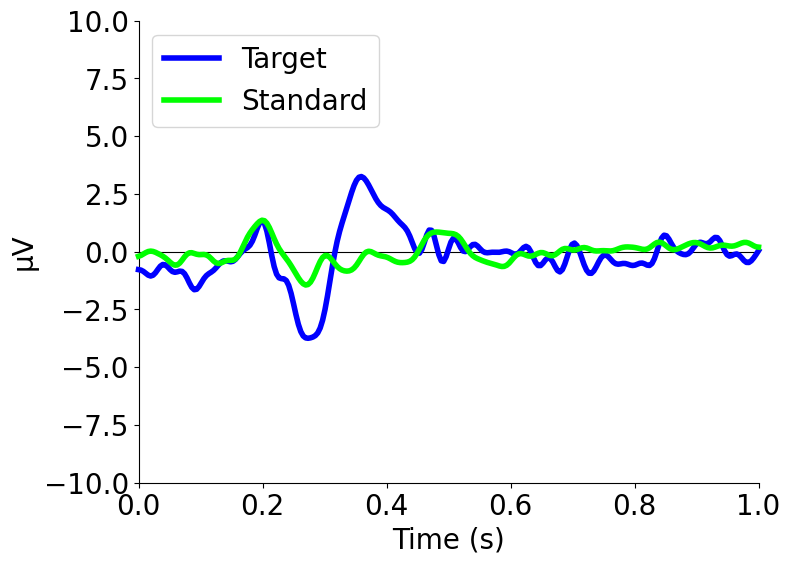

In [29]:
# Visualize the ERP for the single electrode. 
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'lines.linewidth': 4})

overlay_epochs(target_epochs, standard_epochs, channel=channel,yaxis_lims=[-10,10], label_1='Target', label_2='Standard');

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'lines.linewidth': 1})

## Detecting P300 stats

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
+:  TP10 0.359375 3.254670337456943e-06
-:  TP10 0.2734375 -3.7469899911387737e-06
Using a threshold of 1.966707
stat_fun(H1): min=-3.537842 max=5.257453
Running initial clustering …
Found 8 clusters


/Users/ricksugden/Desktop/EEG_analysis/EEG_omics/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 999/999 [00:00<00:00, 2416.91it/s]


cluster start time and p values 0.32421875 [0.001 0.261 0.236 0.952 0.013 0.84  0.328 0.833]
cluster start time and p values 0.25390625 [0.001 0.261 0.236 0.952 0.013 0.84  0.328 0.833]


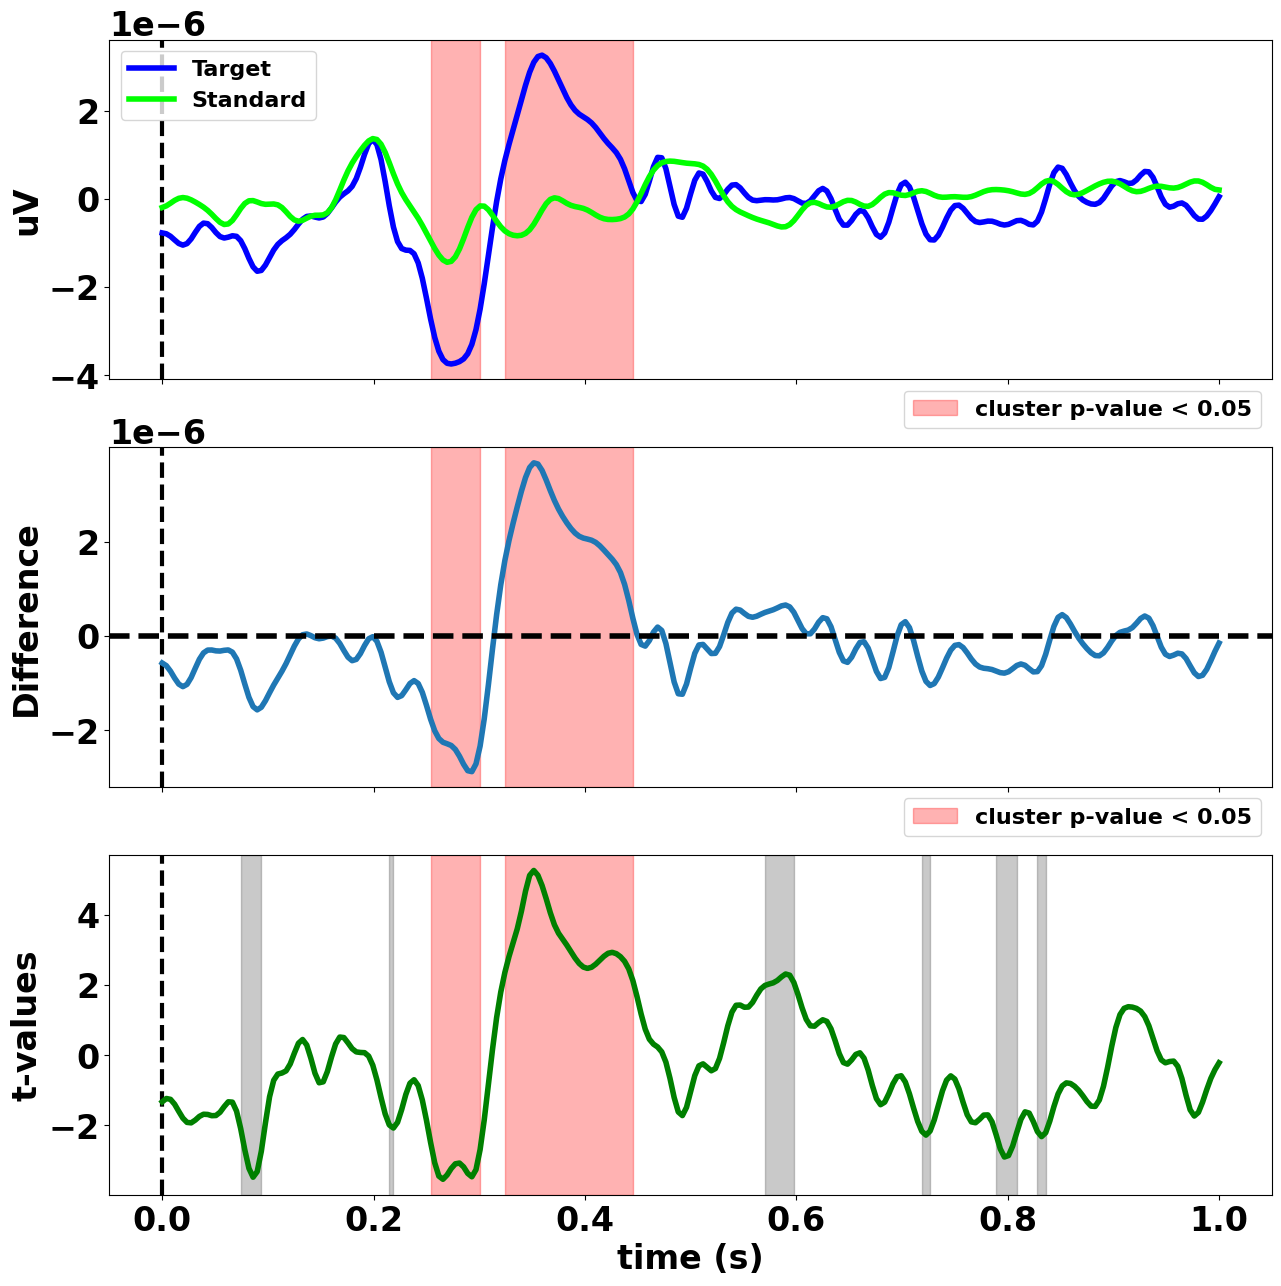

In [30]:
# Transform each condition to array
#condition1 = np.mean(standard_epochs.get_data(), axis=1)
#condition2 = np.mean(target_epochs.get_data(), axis=1)
###############################################################################
#style guide settings
stat_test = 'T'
figure_size = (15,15)
line_thickness=3
plt.rcParams.update({'lines.linewidth': 4})
plt.rcParams["font.weight"] = "bold"

plt.rcParams.update({'font.size': 24})
###############################################################################

target_evoked = target_epochs.average(method='mean')
standard_evoked = standard_epochs.average(method='mean')
target_evoked.comment = 'target'
standard_evoked.comment = 'standard'
#print(target_evoked.shape)
#print(standard_evoked.shape)
p300_channel, p300_peak, p300_amplitude = target_evoked.get_peak(mode='pos', return_amplitude=True)
n200_channel, n200_peak, n200_amplitude = target_evoked.get_peak(tmin=0., mode='neg', return_amplitude=True)
print('+: ', p300_channel, p300_peak, p300_amplitude)
print('-: ', n200_channel, n200_peak, n200_amplitude)

condition1 = target_epochs.get_data()[:,0,:]
condition2 = standard_epochs.get_data()[:,0,:]

np.set_printoptions(precision=5)
###############################################################################
if stat_test == 'F':

  # Permutation test to find significant cluster of differences
  t_vals, clusters, p_vals, h0 = mne.stats.permutation_cluster_test([condition1, condition2], out_type='mask', seed=111)
elif stat_test == 'T':
  shorter_length = min(len(condition1), len(condition2))

  indexes_rand1 = random.sample(range(0, len(condition1)), shorter_length)
  indexes_rand2 = random.sample(range(0, len(condition2)), shorter_length)

  #we need to shortten the standards
  condition3 = condition1[indexes_rand1,:] - condition2[indexes_rand2,:]

  # Permutation test to find significant cluster of differences
  t_vals, clusters, p_vals, h0 = mne.stats.permutation_cluster_1samp_test(condition3, out_type='mask', tail=0, n_permutations=1000, seed=2024)
else:
  assert False, 'error with stat test'
# Visualize
## <string>:1: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figure_size)

times = target_epochs.times
ax0.axvline(x=0, linestyle="--", color="black", linewidth=line_thickness)
## <matplotlib.lines.Line2D object at 0x00000000BFAE7640>
ax0.plot(times, np.mean(condition1, axis=0), label="Target", color = 'blue')
## [<matplotlib.lines.Line2D object at 0x00000000BFAF3D30>]
ax0.plot(times, np.mean(condition2, axis=0), label="Standard", color = 'lime')
## [<matplotlib.lines.Line2D object at 0x00000000BFAF3F40>]
ax0.legend(loc="upper left", prop={'size': 16})
## <matplotlib.legend.Legend object at 0x00000000BFAF3EE0>
ax0.set_ylabel("uV", fontweight='bold')

# Difference
ax1.axvline(x=0, linestyle="--", color="black", linewidth=line_thickness)
ax1.plot(times, condition1.mean(axis=0) - condition2.mean(axis=0))
## [<matplotlib.lines.Line2D object at 0x00000000BFB07B20>]
ax1.axhline(y=0, linestyle="--", color="black")
## <matplotlib.lines.Line2D object at 0x00000000BFB07CD0>
ax1.set_ylabel("Difference", fontweight='bold')

# T-values
ax2.axvline(x=0, linestyle="--", color="black", linewidth=line_thickness)



h = None
for i, c in enumerate(clusters):
    c = c[0]
    if p_vals[i] <= 0.05:
      if times[c.start] >= 0.15 and times[c.stop - 1] <= 0.6:
          h = ax0.axvspan((times[c.start]),
                        (times[c.stop - 1]),
                        color='red',
                        alpha=0.3)
          h = ax1.axvspan((times[c.start]),
                        (times[c.stop - 1]),
                        color='red',
                        alpha=0.3)
          h = ax2.axvspan((times[c.start]),
                        (times[c.stop - 1]),
                        color='red',
                        alpha=0.3)
          print('cluster start time and p values', times[c.start], p_vals)
    else:
        ax2.axvspan((times[c.start]),
                    (times[c.stop - 1]),
                    color=(0.3, 0.3, 0.3),
                    alpha=0.3)

## <matplotlib.patches.Polygon object at 0x00000000BFB16550>
## <matplotlib.patches.Polygon object at 0x00000000BFB16BE0>
hf = ax2.plot(times, t_vals, 'g')
if h is not None:
    ax1.legend((h, ), ('cluster p-value < 0.05', ), prop={'size': 16}, bbox_to_anchor=(1.0,1.2))
    ax2.legend((h, ), ('cluster p-value < 0.05', ), prop={'size': 16}, bbox_to_anchor=(1.0,1.2))
## <matplotlib.legend.Legend object at 0x00000000BFB16D00>
plt.xlabel("time (s)", fontweight='bold')
## Text(0.5, 0, 'time (ms)')
plt.ylabel("t-values", fontweight='bold')
## Text(0, 0.5, 't-values')
#plt.savefig("figures/fig2.png")
plt.savefig(channel[0]+'cluster_permutations.svg',dpi=300)
plt.show()#clf()


In [31]:
p_vals

array([0.001, 0.261, 0.236, 0.952, 0.013, 0.84 , 0.328, 0.833])

## confusion matrix

In [32]:
def plot_confusion_matrix(TP, FP, TN, FN, filename='confusion_matrix_image'):
  cm = 1/2.54 #define inch to cm
  fig, (ax1, axcb) = plt.subplots(1,2,gridspec_kw={'width_ratios':[0.8,0.08]}, sharey=False, figsize = (10*cm, 8*cm))

  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)

  for i in range(FP):
    pred.append(1)
    true.append(0)

  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)


  conf_matrix = sklearn.metrics.confusion_matrix(true, pred)
  cbar_kws = {"ticks": range(0, max([TP, FP, TN, FN]) + 1, max([TP, FP, TN, FN]) // 10)}
  ax1 = sns.heatmap(conf_matrix, cmap='Blues', vmin=0, vmax=max([TP, FP, TN, FN]), ax=ax1, cbar_ax=axcb, annot=True, annot_kws={'fontsize':14}, fmt='g', cbar_kws=cbar_kws)

  for label in ax1.collections[0].colorbar.ax.get_yticklabels():
    label.set_size(10)  # Set your desired font size here

  # labels the title and x, y axis of plot
  #fx.set_title('Insert title here');
  ax1.set_xlabel('Predicted',size=14, fontweight='bold')
  ax1.set_ylabel('Actual ', size=14,  fontweight='bold');

  # labels the boxes
  ax1.xaxis.set_ticklabels(['Standard','Oddball'],size=12)
  ax1.yaxis.set_ticklabels(['Standard','Oddball'],size=12)

  #plt.savefig('controls_MDMclassifier.svg',bbox_inches='tight')

In [33]:
def get_epochs_and_labels(raw, events, bad_channels = [], tmin=0, tmax=0.6, reject_thres=None):
  '''
  INPUT 
  raw: mne raw object containing all data with markers 1=control and 2=target
  bad_channels: list containing bad channels e.g. ['TP9','AF7']
  reject_thres: the peak-to-peak threshold to give mne.Epochs
  OUTPUT
  X: the data as mne.Epochs object with only control and target markers, only EEG, and no bad channels
  y: labels for each epoch as a list e.g. [1,2,1,1,1,2,1,2]
  events_kept: the events kept after applying the reject_threshold
  '''
 
  event_id = dict(control=1, oddball=2)

  #raw.filter(0.5, None, method='iir') # replace baselining with high-pass
  raw.info['bads'] = bad_channels #['AF7','AF8'] # set bad channels
  picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
  
  # Read epochs
  reject = reject_thres #dict(eeg=120) #100 uV
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, reject=reject, picks=picks, baseline=None, preload=True, verbose=False)
  X = epochs.get_data()
  y = epochs.events[:, -1]
  events_kept = epochs.events

  return X, y, events_kept

In [34]:
import pyriemann
from pyriemann.estimation import XdawnCovariances, ERPCovariances
from sklearn.model_selection import train_test_split
random.seed(2024)

def fit_covariance_matrix_get_test_data(X, y, train_size = 0.66, balance_train_classes=False, balance_test_classes=False):

  #initialize covariance matrix
  cov_model = ERPCovariances(estimator='scm');
  #split epochs/labels into train test split
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=42) ;
  #fit the covariance model to the training data, transform was removed
  #print(Xtest.shape, ytest.shape)
  print('Datatype:', Xtest.dtype)

  if balance_train_classes == True:
    oddball_count, standard_count = 0,0
    for y in ytrain:

      if y == 2:
        oddball_count += 1
      elif y == 1:
        standard_count +=1
      else:
        
        assert False, 'error in fit_covariance_matrix_get_test_data'
    
    
    oddball_percentage = oddball_count/(oddball_count + standard_count)
    odd_to_stan_ratio = oddball_count/standard_count

    A = [(x, y) for x, y in zip(Xtrain, ytrain) if y==2 or random.random()<odd_to_stan_ratio]
    x = [x for x, y in A]
    y = [y for x, y in A]
  else:
    x, y = Xtrain, ytrain

  if balance_test_classes == True:
    oddball_count, standard_count = 0,0
    for y in ytest:

      if y == 2:
        oddball_count += 1
      elif y == 1:
        standard_count +=1
      else:
        
        assert False, 'error in fit_covariance_matrix_get_test_data'
    
    
    oddball_percentage = oddball_count/(oddball_count + standard_count)
    odd_to_stan_ratio = oddball_count/standard_count

    A = [(x, y) for x, y in zip(Xtest, ytest) if y==2 or random.random()<odd_to_stan_ratio]
    Xtest = [x for x, y in A]
    ytest = [y for x, y in A]
    
  
  #print(Xtest.shape, ytest.shape)
  Xtest = np.array(Xtest)
  ytest = np.array(ytest)
  print('Datatype:', Xtest.dtype)
  x = np.array(x)
  y = np.array(y)
  cov_model.fit(Xtrain, ytrain);

  return cov_model, Xtest, ytest

In [35]:
from pyriemann.classification import MDM
def reimann_MDM_classifier(covs, Xtest, ytest):
  #initialize classifier
  classifier = MDM(metric='riemann')
  
  #transform the covs model to the test data
  transformed_covs = covs.transform(Xtest)

  #predict classes and probabilities
  predictions = classifier.fit_predict(transformed_covs, ytest); #list of classes [1,1,2,2,1,2,...]
  probabilities = classifier.predict_proba(transformed_covs) # n*2 array of probabilities for each class where each row sums to 1

  accuracy = classifier.score(transformed_covs, ytest)

  return transformed_covs, predictions, probabilities, accuracy

Datatype: float64
Datatype: float64
Based on this many test epochs:  67


{'accuracy': 0.8059701492537313, 'AUROC': 0.8936936936936937}

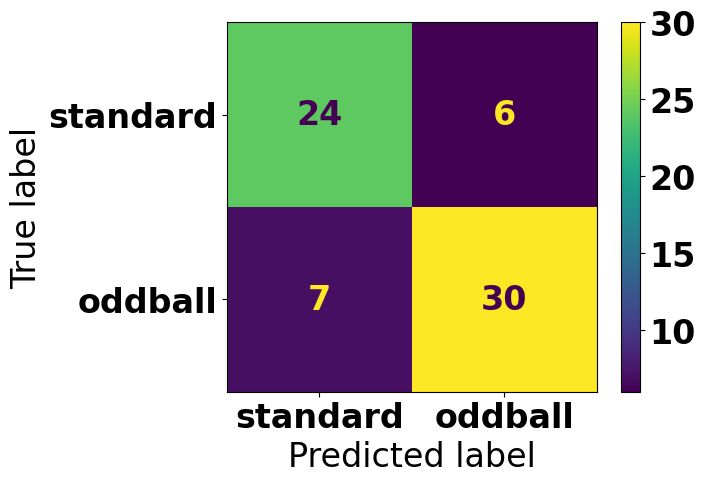

In [36]:
#perform MDM classifier
#Use the raw object to calculate an AUC
random.seed(2024)
X, y, _ = get_epochs_and_labels(raw, events, bad_channels = [], reject_thres={'eeg':100e-6}, tmin=0.2, tmax=0.6)

fitted_cov_model, X_test, y_test = fit_covariance_matrix_get_test_data(X, y, train_size = 0.9, balance_train_classes=False, balance_test_classes=True)

transformed_covs, predictions, probabilities, accuracy = reimann_MDM_classifier(fitted_cov_model, X_test, y_test)

auc = sklearn.metrics.roc_auc_score(y_test, probabilities[:,1]) #this function wants the probabilities for the greatest number label (in our case 2=oddball)

print('Based on this many test epochs: ', len(X_test))
summary_data = {'accuracy':accuracy, 'AUROC':auc}
display(summary_data)



confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=('standard', 'oddball'))
disp.plot()
plt.show()

p_value=  2.138518596107217e-06


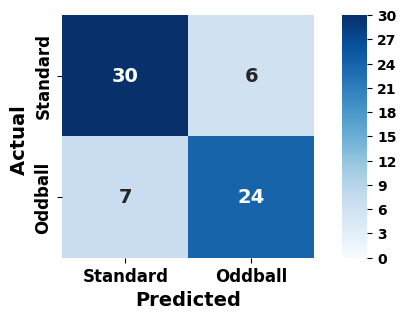

In [37]:
plot_confusion_matrix(TP=24, TN=30, FP=6, FN=7)
chi2, p, dof, ex = stats.chi2_contingency([[24, 6], [7,30]])

print('p_value= ', p)